In [658]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [934]:
def exp_moving_average(x, beta=0.9):
    x = np.array(x)
    v = np.zeros(x.shape)
    v[0] = x[0]
    for i in range(1,x.size):
        v[i] = beta*v[i-1] + (1-beta)*x[i]
    return v

# get average frequency of the time vector
def avrg_fps(x):
    dif = np.gradient(x)
    avrg_fps = np.sum(dif)/dif.size
    return 1/avrg_fps


# inquire interpolated time at nominal time
# nominal time = ms_id/frequency
def interpolate_time_vec(t_vec, t_nom):
    
    def interpolate2points(x1,x2,y1,y2,xt):
        alpha = (xt-x1)/(x2-x1+.0)
        return (1-alpha)*y1 + alpha*y2
        
    res = np.zeros(t_nom.shape)
    for i in range(len(t_vec)-1):
        xt = t_nom[i]
        ind = abs(t_vec-xt).argmin()

        if xt>t_vec[ind]:
            ind=ind
        elif xt<t_vec[ind]:
            ind-=1
        
        if ind >= len(t_vec)-1:
            ind = len(t_vec)-2
            
        res[i] = interpolate2points(t_vec[ind],t_vec[ind+1],t_vec[ind],t_vec[ind+1],xt)
        
    return res


def realign(df1, df2):
    
    if df2.local_time[0] > df1.local_time[0]:
        x = abs(df1.local_time - df2.local_time[0])
        ind0 = x.argmin()
        df1 = df1[ind0:]
        print('Cutting df1')
    
    elif df1.local_time[0] > df2.local_time[0]:
        x = abs(df2.local_time - df1.local_time[0])
        ind0 = x.argmin()
        df2 = df2[ind0:]
        print('Cutting df2')
        
    return df1, df2
        
        

#### Import data

In [935]:
ls ../data

talker_1_2_v0_talker_1.pkl
talker_1_2_v0_talker_2.pkl
talker_1_2_v1_talker_1.pkl
talker_1_2_v1_talker_2.pkl
test_talker_1_2_v10_300_talker_1.pkl
test_talker_1_2_v10_300_talker_2.pkl
test_talker_1_2_v11_100_talker_1.pkl
test_talker_1_2_v11_100_talker_2.pkl
test_talker_1_2_v12_100_talker_1.pkl
test_talker_1_2_v12_100_talker_2.pkl
test_talker_1_2_v3_1000_talker_1.pkl
test_talker_1_2_v3_1000_talker_2.pkl
test_talker_1_2_v4_500_talker_1.pkl
test_talker_1_2_v4_500_talker_2.pkl
test_talker_1_2_v5_500_talker_1.pkl
test_talker_1_2_v5_500_talker_2.pkl
test_talker_1_2_v6_500_reboot_talker_1.pkl
test_talker_1_2_v6_500_reboot_talker_2.pkl
test_talker_1_2_v7_100_talker_1.pkl
test_talker_1_2_v7_100_talker_2.pkl
test_talker_1_2_v7_500_reboot_talker_1.pkl
test_talker_1_2_v7_500_reboot_talker_2.pkl
test_talker_1_2_v8_200_talker_1.pkl
test_talker_1_2_v8_200_talker_2.pkl
test_talker_1_2_v9_200_talker_1.pkl
test_talker_1_2_v9_200_talker_2.pkl


In [936]:
tlk1_path = '../data/test_talker_1_2_v11_100_talker_1.pkl'
tlk2_path = '../data/test_talker_1_2_v11_100_talker_2.pkl'

In [937]:
df1 = pd.read_pickle(tlk1_path)
df2 = pd.read_pickle(tlk2_path)

print(df1.shape, df2.shape)

(156821, 4) (156814, 4)


In [938]:
df1.head(5)

,ms_ids,ros_time,local_time,words
0,0,1.599702e+09,1.599702e+09,talker_1 data
1,1,1.599702e+09,1.599702e+09,talker_1 data
2,2,1.599702e+09,1.599702e+09,talker_1 data
3,3,1.599702e+09,1.599702e+09,talker_1 data
4,4,1.599702e+09,1.599702e+09,talker_1 data


In [939]:
df2.head(5)

,ms_ids,ros_time,local_time,words
0,0,1.599702e+09,1.599702e+09,talker_2 data
1,1,1.599702e+09,1.599702e+09,talker_2 data
2,2,1.599702e+09,1.599702e+09,talker_2 data
3,3,1.599702e+09,1.599702e+09,talker_2 data
4,4,1.599702e+09,1.599702e+09,talker_2 data


### Pre Process

In [940]:
N = 50000
# realign both dataframes so that they will start at the same local time
df1, df2 = realign(df1, df2)

# get fps
fps1 = avrg_fps(df1.local_time)
fps2 = avrg_fps(df2.local_time)
# Rearrange index
df1.index = np.arange(0, df1.shape[0])
df2.index = np.arange(0, df2.shape[0])
# Rearrange msg id in case they are shifted
df1.ms_ids = df1.ms_ids - df1.ms_ids[0]
df2.ms_ids = df2.ms_ids - df2.ms_ids[0]
# Get nominal time
df1['x'] = df1.ms_ids/np.round(fps1)
df2['x'] = df2.ms_ids/np.round(fps2)
# remove offset in time
df1['ros_time_no_offset'] = df1.ros_time - np.array(df1.ros_time)[0]
df2['ros_time_no_offset'] = df2.ros_time - np.array(df2.ros_time)[0]
# remove offset in time
df1['local_time_no_offset'] = df1.local_time - np.array(df1.local_time)[0]
df2['local_time_no_offset'] = df2.local_time - np.array(df2.local_time)[0]

# Interpolate time vector at nominal time
# CAREFUL: time consuming step
# df1['interpolated_local_time'] = interpolate_time_vec(np.array(df1.local_time), df1.x)
# df2['interpolated_local_time'] = interpolate_time_vec(np.array(df2.local_time), df2.x)

# difference in the amount of data packets
# this is needed because, both dataframes has to be of the same size in order to take difference
ndif = df1.shape[0] - df2.shape[0]
if ndif<0:
    df2 = df2[:ndif-1]
    ndif = df1.shape[0] - df2.shape[0]
ndif



Cutting df1


1

In [941]:
print('Frame Rate: ')
print(fps1, fps2)

Frame Rate: 
100.00000236393399 99.99997082461931


In [956]:
print(np.array(df1.local_time[:5]))
print(np.array(df2.local_time[:5]))

[1.59970244e+09 1.59970244e+09 1.59970244e+09 1.59970244e+09
 1.59970244e+09]
[1.59970244e+09 1.59970244e+09 1.59970244e+09 1.59970244e+09
 1.59970244e+09]


### Consistency of Loop Cycle

#### Talker_1

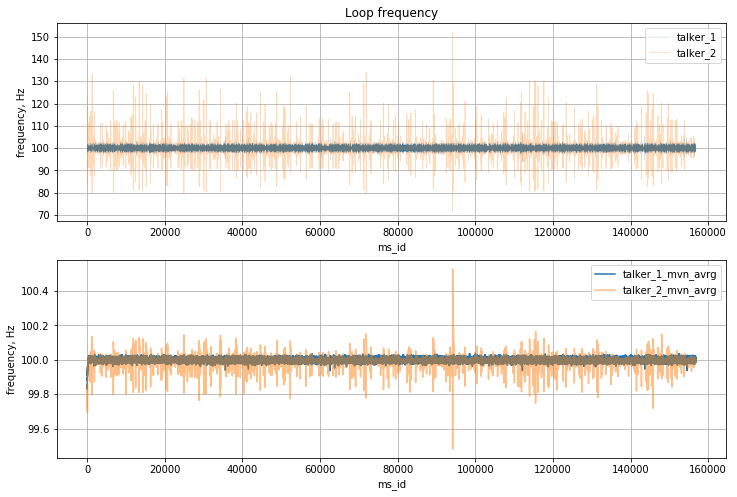

In [942]:
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
fps_t_1 = 1/np.gradient(df1.local_time)
fps_t_2 = 1/np.gradient(df2.local_time)
plt.plot(fps_t_1, alpha=1., LineWidth=.1)
plt.plot(fps_t_2, alpha=0.3, LineWidth=.7)
plt.grid()
plt.xlabel('ms_id')
plt.ylabel('frequency, Hz')
plt.title('Loop frequency')
plt.legend(['talker_1', 'talker_2'])

plt.subplot(2,1,2)
plt.plot(exp_moving_average(fps_t_1, beta=0.99), alpha=1.)
plt.plot(exp_moving_average(fps_t_2, beta=0.99), alpha=0.5)
plt.grid()
plt.xlabel('ms_id')
plt.ylabel('frequency, Hz')
plt.legend(['talker_1_mvn_avrg', 'talker_2_mvn_avrg'])

### Interpolated Time

In [943]:
# plt.figure(figsize=(10,6))
# plt.plot(df1.interpolated_local_time-df2.interpolated_local_time)
# # plt.plot(df2.x, df2.interpolated_local_time)

# plt.grid()

### ROS time comparison

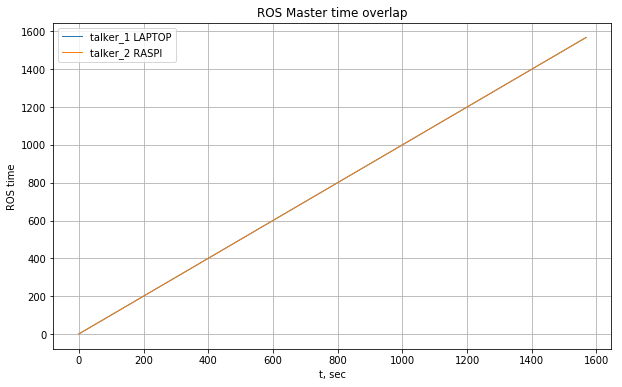

In [944]:
# ROS time overlap plot
plt.figure(figsize=(10,6))
plt.plot(df1.ros_time_no_offset, df1.x, LineWidth=1.)
plt.plot(df2.ros_time_no_offset, df2.x, LineWidth=1.)
plt.grid()
plt.title('ROS Master time overlap')

plt.xlabel('t, sec')
plt.ylabel('ROS time')
plt.legend(['talker_1 LAPTOP', 'talker_2 RASPI'])

### Difference between ROS MASTER time

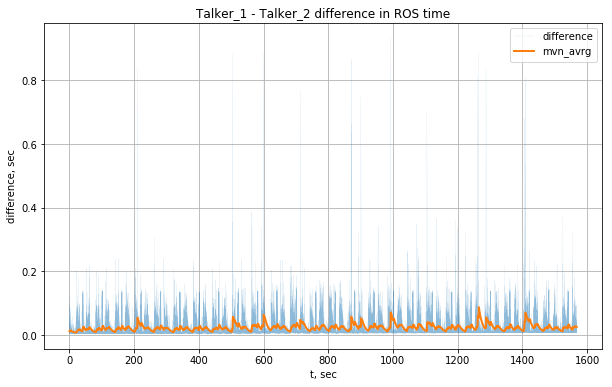

In [945]:
plt.figure(figsize=(10,6))

rdif = np.array(df2.ros_time - df1.ros_time)
rdif = rdif[~np.isnan(rdif)]

rdif_avrg = exp_moving_average(rdif, beta=0.999)

plt.plot(df1.x[:-ndif], rdif, LineWidth=.1, alpha=0.5)
plt.plot(df1.x[:-ndif], rdif_avrg, LineWidth=2.)
plt.grid()

plt.title('Talker_1 - Talker_2 difference in ROS time')
plt.xlabel('t, sec')
plt.ylabel('difference, sec')
plt.legend(['difference', 'mvn_avrg'])


### Local time comparison

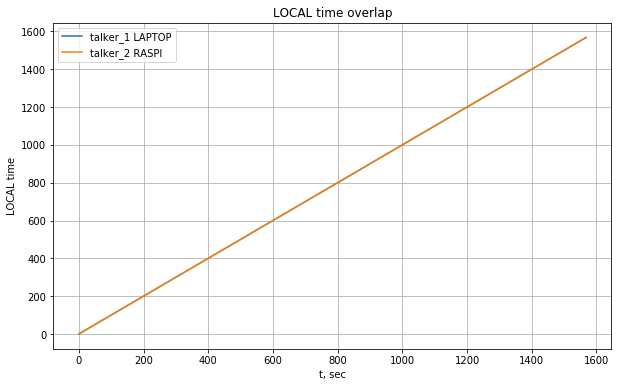

In [946]:
# Local time overlap plot for Talker 1 and 2
plt.figure(figsize=(10,6))
plt.plot(df1.x, df1.local_time_no_offset)
plt.plot(df2.x, df2.local_time_no_offset)
plt.grid()
plt.title('LOCAL time overlap')

plt.xlabel('t, sec')
plt.ylabel('LOCAL time')
plt.legend(['talker_1 LAPTOP', 'talker_2 RASPI'])

### Difference in LOCAL time

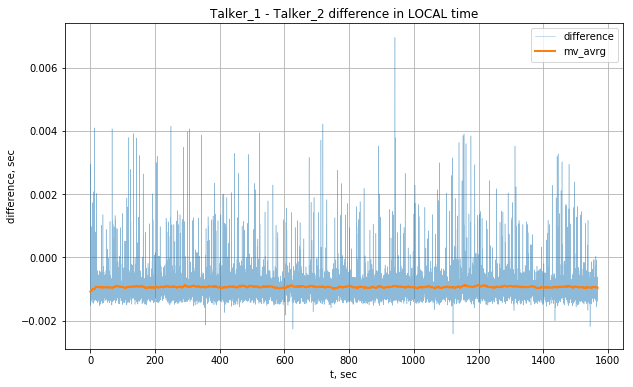

In [958]:
# The difference plot in Local time btwn Talker 1 and Talker 2
ldif = np.array(df2.local_time - df1.local_time)
ldif = ldif[~np.isnan(ldif)]

ldif_avrg = exp_moving_average(ldif, beta=0.999)

plt.figure(figsize=(10,6))
plt.plot(df1.x[:-ndif], ldif, LineWidth=.5, alpha=0.5)
plt.plot(df1.x[:-ndif], ldif_avrg, LineWidth=2.)

# plt.plot(np.log(np.arange(1,ldif_avrg.size+1)),ldif, '--', LineWidth=.5)
# plt.plot(np.log(np.arange(1,ldif_avrg.size+1)), ldif_avrg, LineWidth=3.)

plt.grid()

plt.xlabel('t, sec')
plt.ylabel('difference, sec')
plt.title('Talker_1 - Talker_2 difference in LOCAL time')
plt.legend(['difference', 'mv_avrg'])

### Talker 1 and 2 Difference in ROS time

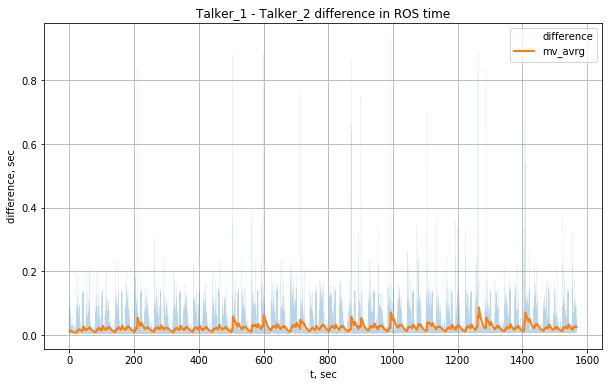

In [948]:

rdif = np.array(df2.ros_time - df1.ros_time)
rdif = rdif[~np.isnan(rdif)]

rdif_avrg = exp_moving_average(rdif, beta=0.999)

plt.figure(figsize=(10,6))
plt.plot(df1.x[:-ndif], rdif, '--', LineWidth=.2, alpha=0.3)
plt.plot(df1.x[:-ndif], rdif_avrg, LineWidth=2.)

# plt.plot(np.log(np.arange(1,ldif_avrg.size+1)),ldif, '--', LineWidth=.5)
# plt.plot(np.log(np.arange(1,ldif_avrg.size+1)), ldif_avrg, LineWidth=3.)

plt.grid()

plt.xlabel('t, sec')
plt.ylabel('difference, sec')
plt.title('Talker_1 - Talker_2 difference in ROS time')
plt.legend(['difference', 'mv_avrg'])

# Time to travel to ROS Master

### ROS and LOCAL time difference

Delay to write transfer laptop to laptop.

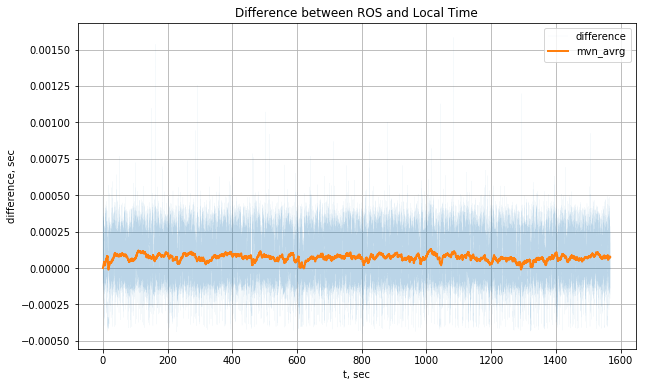

In [949]:
df1['t_diff'] = df1.ros_time_no_offset - df1.local_time_no_offset
df1_tdiff = exp_moving_average(df1.t_diff, beta=0.999)
plt.figure(figsize=(10,6))
plt.plot(df1.x, df1.t_diff,'-.', LineWidth=0.1, alpha=0.3)
plt.plot(df1.x,df1_tdiff, LineWidth=2.)
plt.grid()
plt.xlabel('t, sec')
plt.ylabel('difference, sec')
plt.title('Difference between ROS and Local Time')
plt.legend(['difference', 'mvn_avrg'])

### ROS and LOCAL time difference

This is basically network delay between RasPi and Laptop

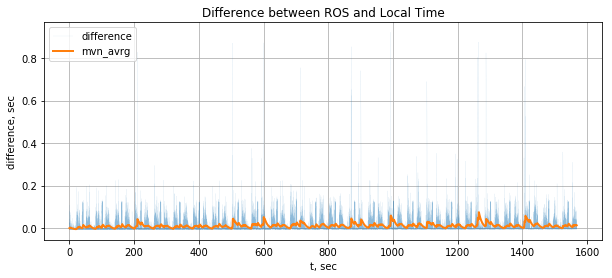

In [950]:
df2['t_diff'] = df2.ros_time_no_offset - df2.local_time_no_offset
df2_tdiff = exp_moving_average(df2.t_diff, beta=0.999)
plt.figure(figsize=(10,4))
plt.plot(df2.x, df2.t_diff,'-.', LineWidth=0.1, alpha=0.5)
plt.plot(df2.x, df2_tdiff, LineWidth=2.)
plt.grid()
plt.xlabel('t, sec')
plt.ylabel('difference, sec')
plt.title('Difference between ROS and Local Time')
plt.legend(['difference', 'mvn_avrg'])